# Classifying Patient Abilify Ratings from WebMD
https://www.kaggle.com/datasets/joyshil0599/abilify-oral-reviews-dataset

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import gensim

## Download WordNet Model for Lemmatization

In [2]:
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [3]:
corpus = pd.read_csv('/kaggle/input/abilify-oral-reviews-dataset/abilify_ora_effected_peple_reviewl.csv', encoding_errors='replace') # use replacement character for characters not in UTF-8
corpus.head(5)

,Time of Meditation,Suspect name,Age,Gender,Suspect Status,Date,Condition,overall-rating,description-text
0,2 to less than 5 years,Barbara,65-74,Female,Patient,2/13/2023,Bipolar Disorder in Remission,5.0,I've taken Abilify to augment bupropion for Bi...
1,1 to 6 months,Matt,35-44,Male,Patient,2/9/2023,Schizophrenia,2.0,Worked for 3 months. Waste of time. You think ...
2,1 to 6 months,Alex Adams,25-34,Male,Patient,1/5/2023,Schizophrenia,2.3,Worked really well for like 2 months then I go...
3,1 to less than 2 years,Jill,35-44,Female,Patient,12/28/2022,Additional Medications to Treat Depression,1.0,This is the worst drug on the market. It cause...
4,1 to 6 months,Anonymous,45-54,Female,Patient,12/7/2022,Additional Medications to Treat Depression,2.0,I was prescribed as a child at 15 years old. I...


In [4]:
corpus = corpus[['overall-rating', 'description-text']]
print(len(corpus))
corpus.head(5)

1835


,overall-rating,description-text
0,5.0,I've taken Abilify to augment bupropion for Bi...
1,2.0,Worked for 3 months. Waste of time. You think ...
2,2.3,Worked really well for like 2 months then I go...
3,1.0,This is the worst drug on the market. It cause...
4,2.0,I was prescribed as a child at 15 years old. I...


In [5]:
corpus = corpus.dropna(axis=0)
print(len(corpus))
corpus = corpus.reset_index(drop=True)

1540


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


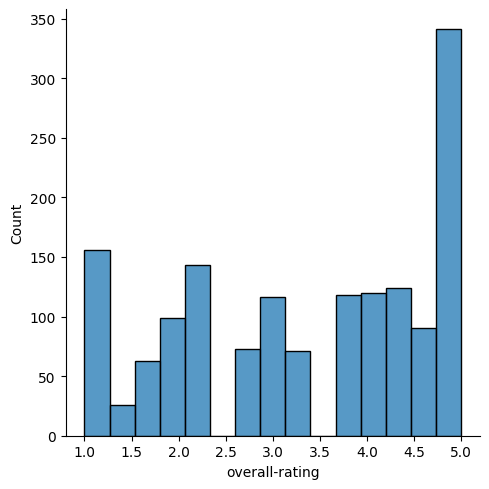

In [6]:
# fix histogram ticks
sns.displot(corpus, x='overall-rating', bins=15)

<Axes: xlabel='rating_rounded', ylabel='count'>

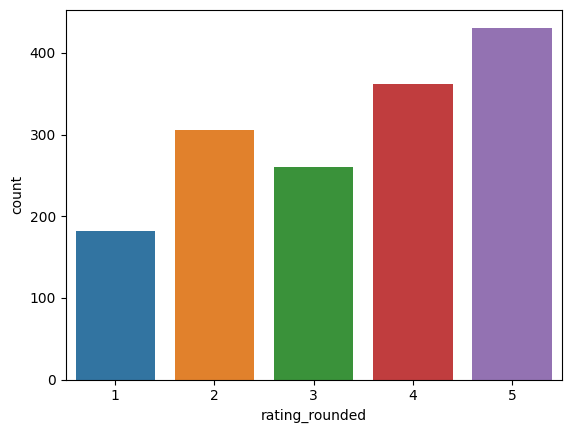

In [7]:
corpus['rating_rounded'] = corpus['overall-rating'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

In [8]:
# https://geeksforgeeks.org/python-word-embedding-using-word2vec/
# https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/

In [9]:
# make into sklearn pipeline

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# add spell checking
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    # tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_punct]
    sentence = ' '.join(tokens_lemmatized)
    return sentence

In [10]:
corpus['text_preprocessed'] = corpus['description-text'].apply(preprocess_text)
corpus['text_preprocessed'].head(5)

0    i 've taken abilify to augment bupropion for b...
1    worked for 3 month waste of time you think you...
2    worked really well for like 2 month then i got...
3    this is the worst drug on the market it caused...
4    i wa prescribed a a child at 15 year old it ca...
Name: text_preprocessed, dtype: object

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(oov_token='<OOV>', num_words=VOCAB_SIZE)

sentences = corpus['text_preprocessed']

# generate word indexes
tokenizer.fit_on_texts(sentences)

# generate sequences and apply padding
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [12]:
words_sentences = [x.split() for x in sentences]

## Bag of Words and Naive Bayes
Natural Language Processing in Action

In [13]:
from collections import Counter                                    

bags_of_words = [Counter(sentence) for sentence in words_sentences]
df_bows = pd.DataFrame.from_records(bags_of_words)                  
df_bows = df_bows.fillna(0).astype(int)
df_bows.head(5)

,i,'ve,taken,abilify,to,augment,bupropion,for,bipolar,disorder,...,true,unhappy,environment,behind,wheel,full-blown,interferes,exhuasted,weekend,alleviating
0,4,2,1,1,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train = df_bows[:1200]
X_test = df_bows[1200:]

y_train = corpus['rating_rounded'][:1200] - 1
y_test = corpus['rating_rounded'][1200:] - 1

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

In [15]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_subset, y_train_subset)

y_pred = model.predict(X_test_subset)

accuracy: 0.8092


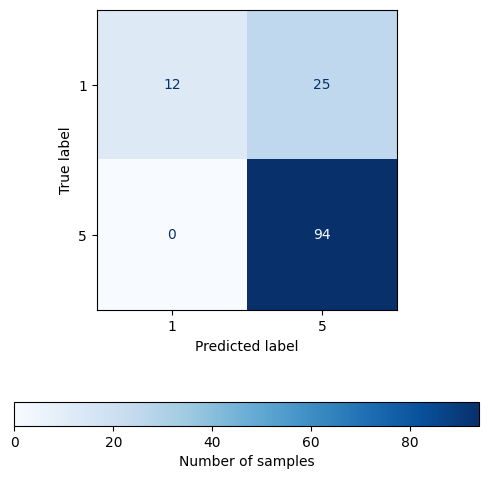

In [16]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

print(f'accuracy: {accuracy_score(y_test_subset, y_pred):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cm = confusion_matrix(y_test_subset, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=[1, 5])
cm_plot.plot(cmap='Blues', ax=ax)
im = cm_plot.im_
im.colorbar.remove()
plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

plt.title('');

In [17]:
one_star_misclassified = X_test_subset[(y_test_subset == 0) & (y_pred == 1)]
for row in one_star_misclassified.iterrows():
    print(one_star_misclassified.columns[row[1] != 0])

Index(['i', 'abilify', 'to', 'for', 'it', 'side', 'effect', 'the', 'a',
       'could', 'n't', 'so', 'my', 'off', 'is', 'drug', 'caused', 'me', 'they',
       'did', 'nothing', 'than', 'have', 'take', 'say', 'immediately', 'why',
       'worse', 'guess', 'pain', 'fast', 'sever', 'fibromyalgia', 'reaction',
       'center', 'imagine'],
      dtype='object')
Index(['i', 'abilify', 'for', 'bipolar', 'disorder', 'been', 'month', '2',
       'wa', 'having', 'on', 'have', 'yr', 'but', 'great', 'feel', 'am',
       'trouble', 'lithium', 'w/', '11', 'hyperglycemia'],
      dtype='object')
Index(['i', 'to', 'it', 'had', 'a', 'worked', 'well', 'so', 'wa', 'just',
       'this', 'is', 'started', 'how', 'else', 'post', 'today', 'wondering',
       'here', 'everyone', 'comment', 'eith'],
      dtype='object')
Index(['i', ''ve', 'abilify', 'for', 'been', 'had', 'the', 'do', 'n't', 'my',
       'ha', 'this', 'is', 'on', 'have', 'but', 'anyone', 'only', 'way', 'up',
       'being', 'sleep', 'since', '

In [18]:
EMBEDDING_DIM = 300

w2v_file = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)

In [19]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [20]:
word_index = tokenizer.word_index
word_list = sorted(word_index.items(), key=lambda x:x[1])
word_list = [x[0] for x in word_list]

embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array([w2v_model[word] if word in w2v_model else np.zeros(EMBEDDING_DIM) for word in word_list])])

In [21]:
np.array(word_list)[np.sum(embedding_matrix[1:], axis=1)==0]

array(['<OOV>', 'and', 'to', 'a', 'of', 'abilify', "'s", '10', "''", '15',
       '30', '10mg', '50', '20', '15mg', '40', '60lbs', '20mg', 'pristiq',
       'ocd', '300mg', '100', '14', 'ablify', '60', 'trazadone', 'wasnt',
       '700', '18', 'ptsd', '25', 'geodon', '300', '30mg', '00', '12',
       '45', '1wk', '60mg', '24', 'ambilify', 'didnt', 'it�s', "tic'ing",
       '80', '16', 'lightheadness', 'risperdal', 'abilfy', '150mg',
       '40lbs', '100mg', '500', '38', '99', '70lbs', 'i�ve', '250mg',
       'luvox', '200', '35', 'ssri', '17', '90', 'remeron', 'cogentin',
       '200mg', '20lbs', '19', 'naushish', 'delousions', 'deffently',
       'pristq', 'stabalizede', 'doesnt', 'tmj', 'ariproprazole',
       'pyschiatrists', 'kolopin', 'deppression', 'lemictal', '150',
       '25mg', '225mg', '125', '2009', 'saphris', 'webmd', '30lbs', '11',
       '09', 'clonic', 'benztropine', 'akathesia', 'wbc', '13', 'torette',
       '50mg', 'grey', '117', 'i�ll', '600mg', '450', '40mg', 'viib

In [22]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [23]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import Model

# 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [24]:
X_train = sequences_padded[:1200]
X_test = sequences_padded[1200:]

y_train = corpus['rating_rounded'][:1200] - 1
y_test = corpus['rating_rounded'][1200:] - 1

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

In [25]:
from sklearn.utils import class_weight

classes = [0, 1]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_subset)
class_weights = dict(enumerate(class_weights))

In [26]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=32,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
14/14 [==============================] - 3s 93ms/step - loss: 0.7069 - accuracy: 0.5658 - val_loss: 0.6793 - val_accuracy: 0.7143
Epoch 2/50
14/14 [==============================] - 1s 73ms/step - loss: 0.6933 - accuracy: 0.5335 - val_loss: 0.6755 - val_accuracy: 0.7143
Epoch 3/50
14/14 [==============================] - 1s 66ms/step - loss: 0.6891 - accuracy: 0.5935 - val_loss: 0.6770 - val_accuracy: 0.6939
Epoch 4/50
14/14 [==============================] - 1s 66ms/step - loss: 0.6752 - accuracy: 0.6074 - val_loss: 0.6472 - val_accuracy: 0.7551
Epoch 5/50
14/14 [==============================] - 1s 68ms/step - loss: 0.6537 - accuracy: 0.5797 - val_loss: 0.5452 - val_accuracy: 0.7755
Epoch 6/50
14/14 [==============================] - 1s 70ms/step - loss: 0.5944 - accuracy: 0.7021 - val_loss: 0.5091 - val_accuracy: 0.7959
Epoch 7/50
14/14 [==============================] - 1s 69ms/step - loss: 0.5234 - accuracy: 0.7644 - val_loss: 0.5882 - val_accuracy: 0.7755
Epoch 8/50
14

accuracy: 0.8092


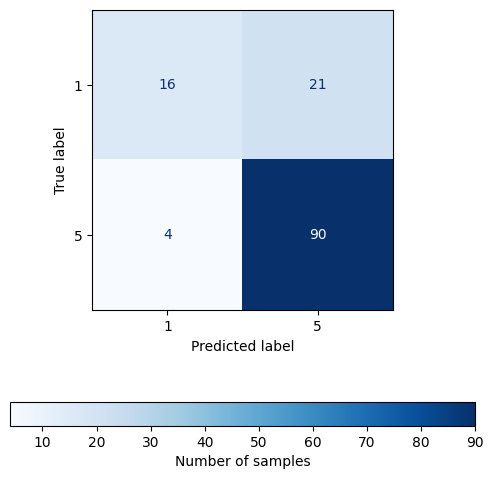

In [27]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

print(f'accuracy: {accuracy_score(y_test_subset, y_pred_label):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cm = confusion_matrix(y_test_subset, y_pred_label)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=[1, 5])
cm_plot.plot(cmap='Blues', ax=ax)
im = cm_plot.im_
im.colorbar.remove()
plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

plt.title('');

In [28]:
# 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Conv1D(64, 3, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
classes = [0, 1, 2, 3, 4]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(enumerate(class_weights))

In [30]:
model.fit(X_train,
          y_train,
          epochs=50,
          batch_size=32,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
34/34 [==============================] - 4s 100ms/step - loss: 1.6197 - accuracy: 0.2519 - val_loss: 1.6035 - val_accuracy: 0.3000
Epoch 2/50
34/34 [==============================] - 4s 105ms/step - loss: 1.5509 - accuracy: 0.3778 - val_loss: 1.6254 - val_accuracy: 0.2500
Epoch 3/50
34/34 [==============================] - 3s 93ms/step - loss: 1.3620 - accuracy: 0.4769 - val_loss: 1.6154 - val_accuracy: 0.2917
Epoch 4/50
34/34 [==============================] - 3s 96ms/step - loss: 1.0986 - accuracy: 0.6167 - val_loss: 1.6456 - val_accuracy: 0.2667
Epoch 5/50
34/34 [==============================] - 3s 93ms/step - loss: 0.8680 - accuracy: 0.7185 - val_loss: 1.8295 - val_accuracy: 0.2667
Epoch 6/50
34/34 [==============================] - 3s 93ms/step - loss: 0.7372 - accuracy: 0.7787 - val_loss: 1.7920 - val_accuracy: 0.3333
Epoch 7/50
34/34 [==============================] - 3s 93ms/step - loss: 0.5958 - accuracy: 0.8130 - val_loss: 2.0958 - val_accuracy: 0.3750
Epoch 8/50


accuracy: 0.3412


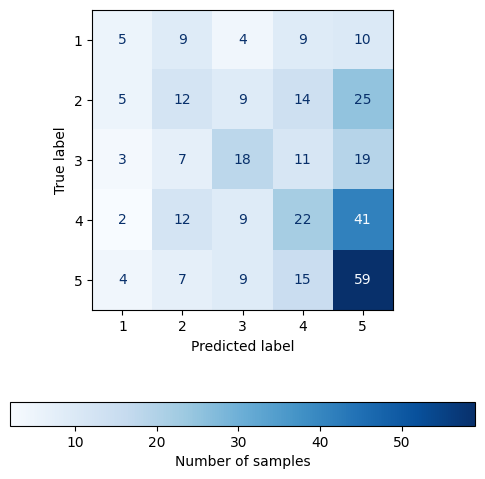

In [31]:
print(f'accuracy: {accuracy_score(y_test, y_pred_label):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_label)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=[1, 2, 3, 4, 5])
cm_plot.plot(cmap='Blues', ax=ax)
im = cm_plot.im_
im.colorbar.remove()
plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

plt.title('');